In [1]:
import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std
import numpy
%matplotlib inline


19.0.0


Setting up file paths we are looking at

In [2]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

"QE flats" are the flat images taken for deriving Quantumn Efficiency as a function of wavelengths. We take a flat image with a monochrometer which produces light in a narrow wavelength, and compare the light level obsereved with the absolute measurement. For the absolute measurement of light source we also monitor the light level by using a calibrated photodiode independently but simultaneously. We know photons input and photons observed. Using these numbers we can calculate how much photons is converted to electron -- which is QE.

Anyway, we use this data set for the different purpose. We use this set for making a broadband flat.

Let's see how qeflatpath is organized

In [109]:
for i, apath in enumerate(qeflatpath):
    print(i,apath)

0 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0320_10982_20190518214321.fits
1 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0325_10982_20190518214833.fits
2 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0350_10982_20190518215337.fits
3 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0375_10982_20190518215701.fits
4 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0400_10982_20190518215953.fits
5 /gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/ITL-3800C-318_lambda_flat_0425_10982_201905

Construct an array of wavelengths where QE acquistions were made

In [4]:
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])

Let's use SDSS QE for now. Download the QE from the official page. https://www.sdss.org/instruments/camera/

In [5]:
!wget -O filter_curves.fits https://www.sdss.org/wp-content/uploads/2017/04/filter_curves.fits

--2020-07-06 22:59:25--  https://www.sdss.org/wp-content/uploads/2017/04/filter_curves.fits
Resolving www.sdss.org (www.sdss.org)... 128.220.233.141
Connecting to www.sdss.org (www.sdss.org)|128.220.233.141|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34560 (34K) [image/fits]
Saving to: ‘filter_curves.fits’

100%[======================================>] 34,560      --.-K/s   in 0.07s   

2020-07-06 22:59:26 (519 KB/s) - ‘filter_curves.fits’ saved [34560/34560]



Let's plot it, to see how it looks. The wavelength is given in angstrom. Need to convert to nanometer, or vice verca. The crosses are also shown to show how interpolation works. Interpolation sometimes gives crazy result. Checking consistency by making a plot is always a good idea.

Text(0.5, 0, 'Angstrom')

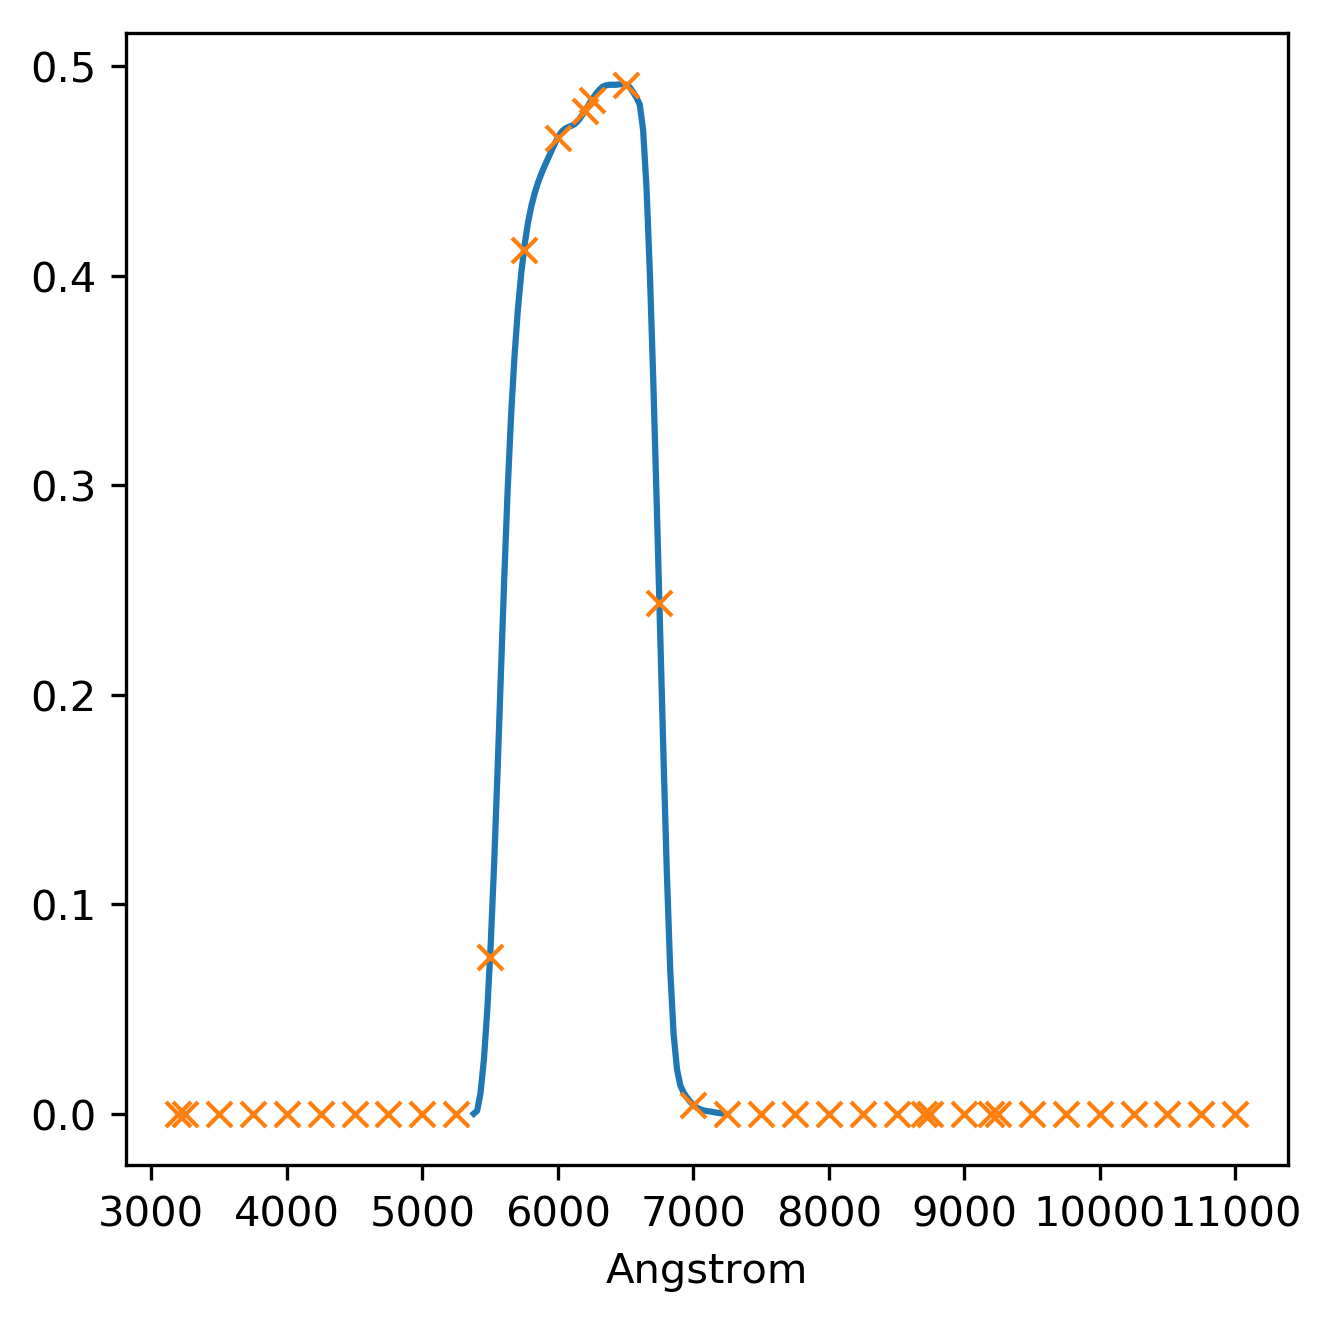

In [110]:
fig, axs = pylab.subplots(figsize=(5,5),dpi=300) 

# [('wavelength', '>f4'), ('respt', '>f4'), ('resbig', '>f4'), ('resnoa', '>f4'), ('xatm', '>f4')]
sdssfilter = fits.open("filter_curves.fits")
pylab.plot(sdssfilter[3].data["wavelength"],sdssfilter[3].data["respt"])
weights = numpy.interp(wls*10,sdssfilter[3].data["wavelength"],sdssfilter[3].data["respt"])
pylab.plot(wls*10,weights,"x")
pylab.xlabel("Angstrom")

Sum up QE flats weighted by QE
\begin{eqnarray}
    \hat{F}=\frac{\sum_i F(\lambda_i)R(\lambda_i)}{\sum_iR(\lambda_i)}
\end{eqnarray}

In [111]:
superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark, (but haven't used anywhere)
superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias

arr = []        # defines an empty array for storing new combined flat
ch = 1          # defines a channel we'll explore in the following:
for i, aqeflatpath in enumerate(qeflatpath):
    aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)
    img = aqeflat.unbiased_and_trimmed_image(ch).getImage().array
    arr.append(img*weights[i])

10300.814
12450.047
23304.49
21113.143
19841.318
19336.428
19614.969
19785.604
19788.828
20212.246
20415.828
20165.871
20049.97
20133.34
20042.951
20003.887
19941.36
19774.158
19635.65
19823.977
19491.973
19578.748
19580.248
19290.607
19677.451
19530.463
19506.744
19532.225
19551.521
19247.645
19100.53
18818.676
7327.108
4683.2656
1534.229
600.66754


Let's see how the combined flat looks like.

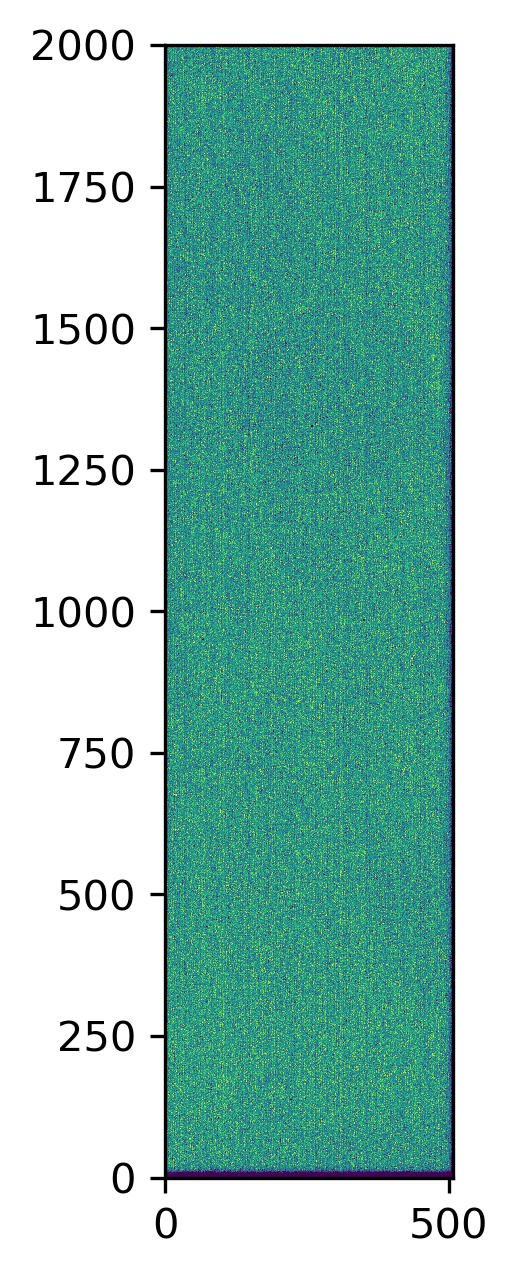

In [37]:
fig, axs = pylab.subplots(figsize=(5,5),dpi=300) 
img = numpy.sum(arr,axis=0)/numpy.sum(weights)
mean = img.mean()
std = mad_std(img)
N = 3
pylab.imshow(img,vmin=mean-N*std,vmax=mean+N*std,origin="lower")

Here we load additional fits files for comparison. CCOB synthesized flats in R and B. We'll use the mean of the CCOB R flat as the normalization. We'll scale all other images so that their mean numbers match with the CCOB R flat.

In [38]:
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
ccob_red = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_red,ch,["imaging"])["imaging"]))
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_uv_-211.815_-0.395.fits"
ccob_blue = get_ccd_from_id(None, fname, [])
print ( mad_std(get_data_as_read(ccob_blue,ch,["imaging"])["imaging"]))

# normalize flat 
red = get_data_as_read(ccob_red,ch,["imaging"])["imaging"]
blue = get_data_as_read(ccob_blue,ch,["imaging"])["imaging"]

normedimg = img/img.mean()*red.mean()

464.05449439225345
431.4372455851302


# Direct comparison
Here we'll see how they look side-by-side.

430.4642878792359
464.05449439225345
0.004748887353534049


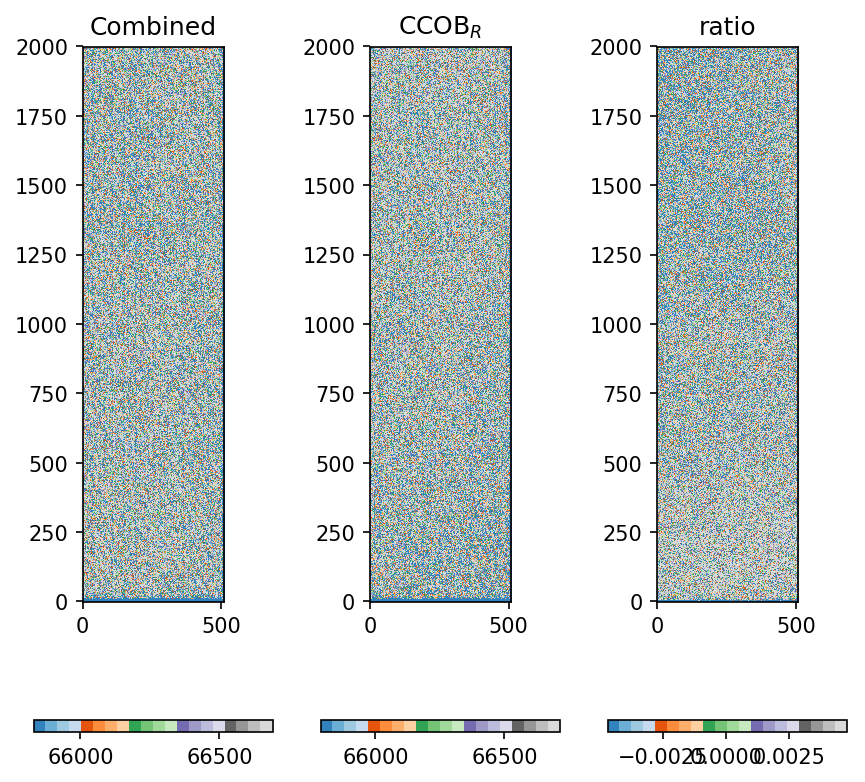

In [39]:
fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150) 
for ax, animg, label in zip(axs,[normedimg, red, (normedimg-red)/red], ["Combined",r"CCOB$_{R}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    N = 1
    ax.set_title(label)
    im = ax.imshow(animg,vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)

What happens if comparing red and blue? It is noisy but some structure can be seen in the ratio panel.

485.447981092096
464.05449439225345
0.006003453156509916


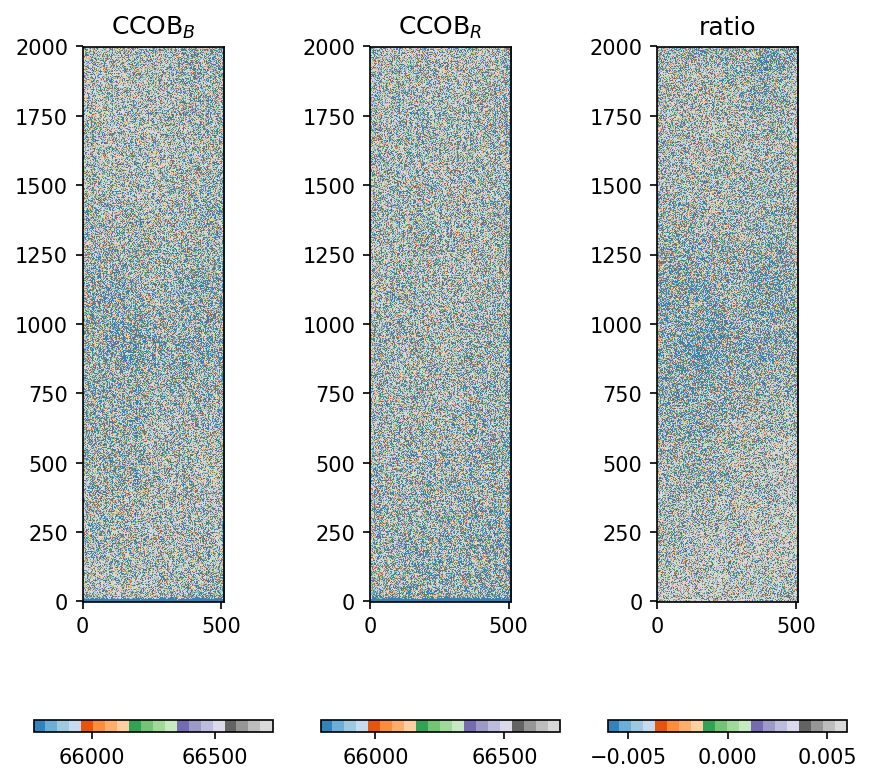

In [64]:
fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150)
normedblue = blue/blue.mean()*red.mean()
for ax, animg, label in zip(axs,[normedblue, red, (normedblue-red)/red], [r"CCOB$_{B}$",r"CCOB$_{R}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    N = 1
    ax.set_title(label)
    im = ax.imshow(animg,vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)

Noise depends on flux levels. We'll pick a flat pairs at the same flux level we are exploring by calculating mean for all flat pairs.

In [41]:
flatpairs = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/flat_pair_raft_acq/v0/85183/S21/ITL-3800C-318_flat_*_flat?*.fits")
flatpairs.sort()
for i, aflatpair in enumerate(flatpairs):
    aqeflat = get_ccd_from_id(None, aflatpair, [], bias_frame=superbias)
    img = aqeflat.unbiased_and_trimmed_image(ch).getImage().array
    print("{:02d}   {}   {:05f}".format(i, os.path.basename(aflatpair), img.mean()))


00   ITL-3800C-318_flat_0000.46s_flat1_10982_20190518181820.fits   96.660767
01   ITL-3800C-318_flat_0000.46s_flat2_10982_20190518181854.fits   99.103783
02   ITL-3800C-318_flat_0000.60s_flat1_10982_20190518181934.fits   133.241119
03   ITL-3800C-318_flat_0000.60s_flat2_10982_20190518181952.fits   134.069016
04   ITL-3800C-318_flat_0000.83s_flat1_10982_20190518182017.fits   184.084671
05   ITL-3800C-318_flat_0000.83s_flat2_10982_20190518182036.fits   187.658585
06   ITL-3800C-318_flat_0001.11s_flat1_10982_20190518182101.fits   249.398544
07   ITL-3800C-318_flat_0001.11s_flat2_10982_20190518182120.fits   249.092651
08   ITL-3800C-318_flat_0001.48s_flat1_10982_20190518182147.fits   333.594086
09   ITL-3800C-318_flat_0001.48s_flat2_10982_20190518182207.fits   338.782928
10   ITL-3800C-318_flat_0001.89s_flat1_10982_20190518182450.fits   983.985352
11   ITL-3800C-318_flat_0001.89s_flat2_10982_20190518182512.fits   981.403625
12   ITL-3800C-318_flat_0002.46s_flat1_10982_20190518182541.fits  

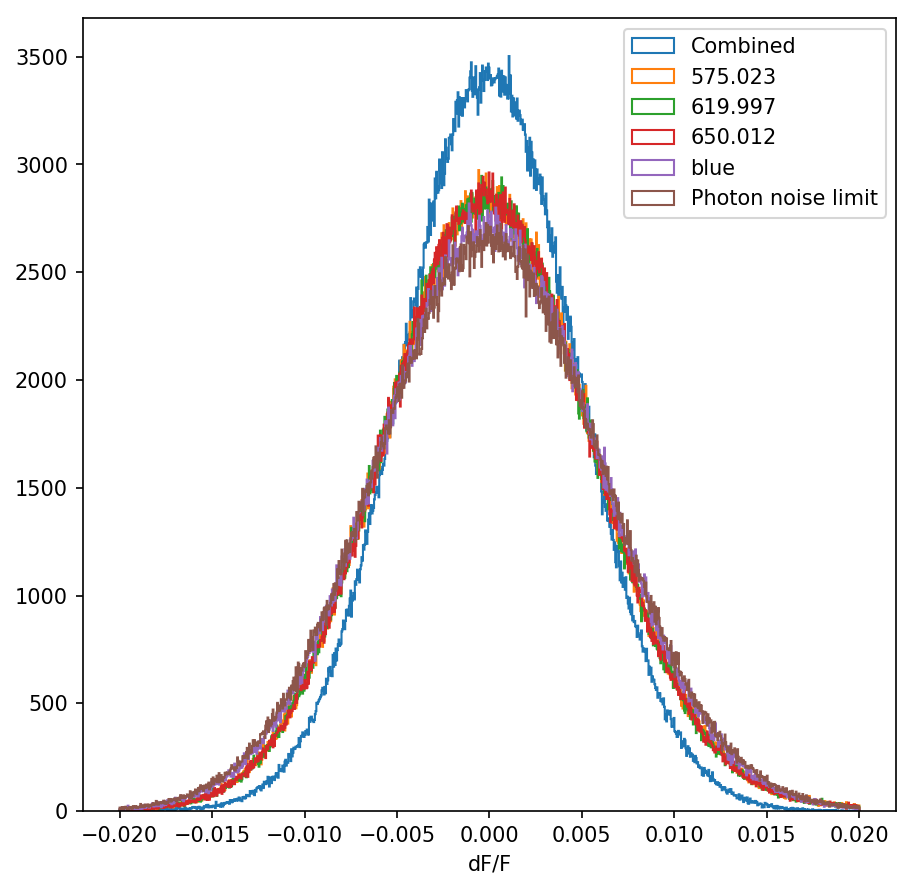

In [48]:
fig, axs = pylab.subplots(1,1,figsize=(7,7),dpi=150)

def getonewl( num ):
    fname = qeflatpath[num]
    ccd_particular = get_ccd_from_id(None, fname, [])
    particular = get_data_as_read(ccd_particular,ch,["imaging"])["imaging"]
    normedparticular = particular/particular.mean()*red.mean()
    return normedparticular.flatten(),  ccd_particular.md.md["MONOWL"]

for anarray, label in [
            ( normedimg.flatten(), "Combined" ),
            getonewl(11),
            getonewl(13),
            getonewl(15),
            ( normedblue.flatten(), "blue" ),
#            ( red.mean(), r"$\langle {\rm red}\rangle$-red" )    
    ]:
    arr = (anarray-red.flatten())/red.flatten()
    pylab.hist(arr-numpy.median(arr),
               bins=1000,range=(-0.02,0.02),histtype="step",label=label)
#30,31   #20k
#52,53   #60k
#76,77
a=get_ccd_from_id(None, flatpairs[30], [], bias_frame=superbias).unbiased_and_trimmed_image(ch).getImage().array # one of flat pairs which have almost same flux level as R. (~20k)
b=get_ccd_from_id(None, flatpairs[31], [], bias_frame=superbias).unbiased_and_trimmed_image(ch).getImage().array
rand = ( a-b ).flatten()/(b.flatten())/numpy.sqrt(2)
pylab.hist(
    rand-numpy.median(rand),
    bins=1000,range=(-0.02,0.02),histtype="step",label="Photon noise limit"
)
pylab.xlabel("dF/F")
pylab.legend()

The residual distribution is roughly consistent with the photon noise. Pixel-by-pixel comparison will not work.

# Introducing spatial filtering
Wile giving up the pixel-by-pixel comparison, we introduce spatial filtering instead.

In [57]:
from scipy.ndimage import gaussian_filter

430.4642878792359
464.05449439225345
0.004748887353534049


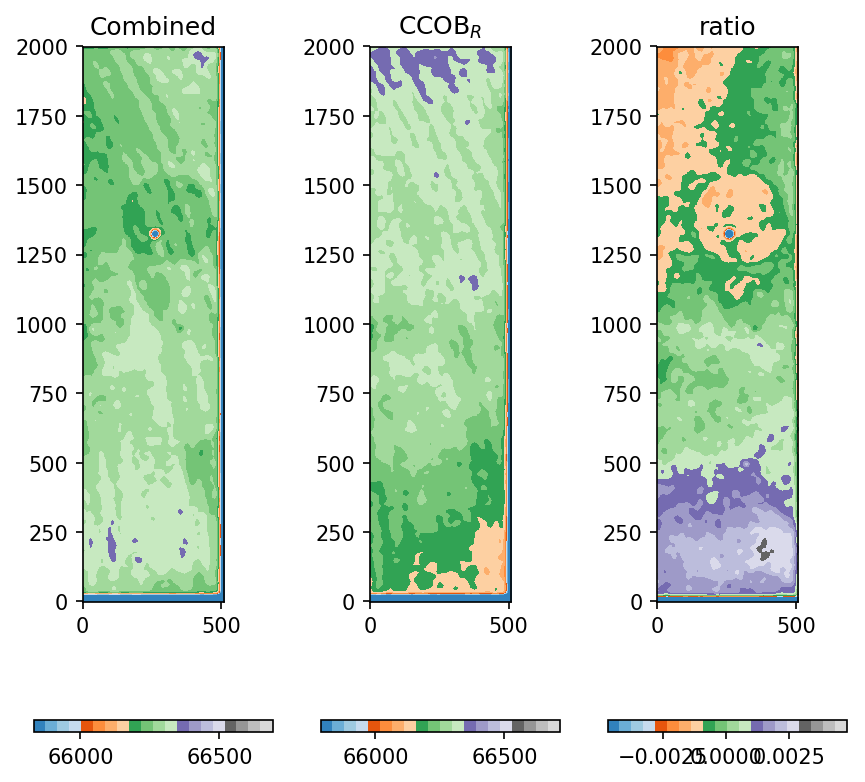

In [121]:
sigma=10
N = 1

fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150) 
for ax, animg, label in zip(axs,[normedimg, red, (normedimg-red)/red], ["Combined",r"CCOB$_{R}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    ax.set_title(label)
    im = ax.imshow(gaussian_filter(animg,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)

- In the combined flat, there is a circular shape. It could be a shadow of a dust on the window. 
 - It might be possible that the small circle in the circle caused this if the small circle is a dust on the surface and it reflects light and bouncing back to CCD by the window.
- Looking at the CCOB flat, the gradient across top-to-bottom seems to exist. 
- The ratio, the residuals of the combined flat from CCOB$_R$ divided by CCOB_$R$, the gradient is enhanced and becomes easily visible. It is ~0.3% level.
- Tree rings are washed out.

485.447981092096
464.05449439225345
0.006003453156509916


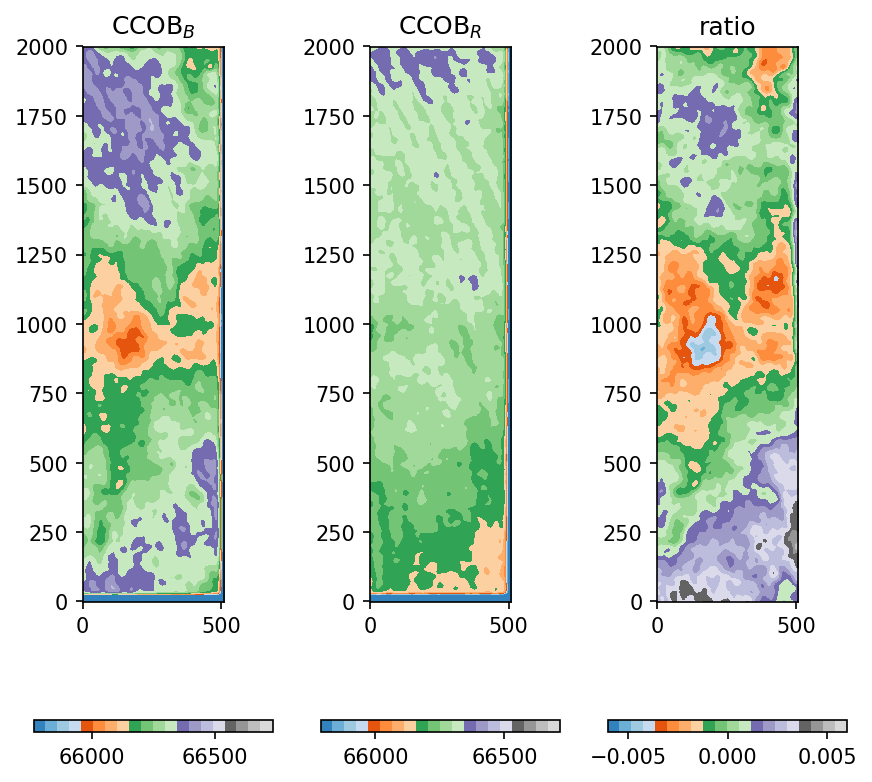

In [113]:
fig, axs = pylab.subplots(1,3,figsize=(7,7),dpi=150)
normedblue = blue/blue.mean()*red.mean()
for ax, animg, label in zip(axs,[normedblue, red, (normedblue-red)/red], [r"CCOB$_{B}$",r"CCOB$_{R}$","ratio"]):
    mean = numpy.median(animg)
    std = mad_std(animg)
    ax.set_title(label)
    im = ax.imshow(gaussian_filter(animg,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))
    fig.colorbar( im, ax=ax, orientation="horizontal")
    print(std)

- For the comparison, this plot illustrates how badly behaved when we used different flat.
- The level of inconsistency approaches to 0.5% level.
- The tree rings are also washed.

0.21%
0.16%
0.14%
0.14%
0.14%
0.14%


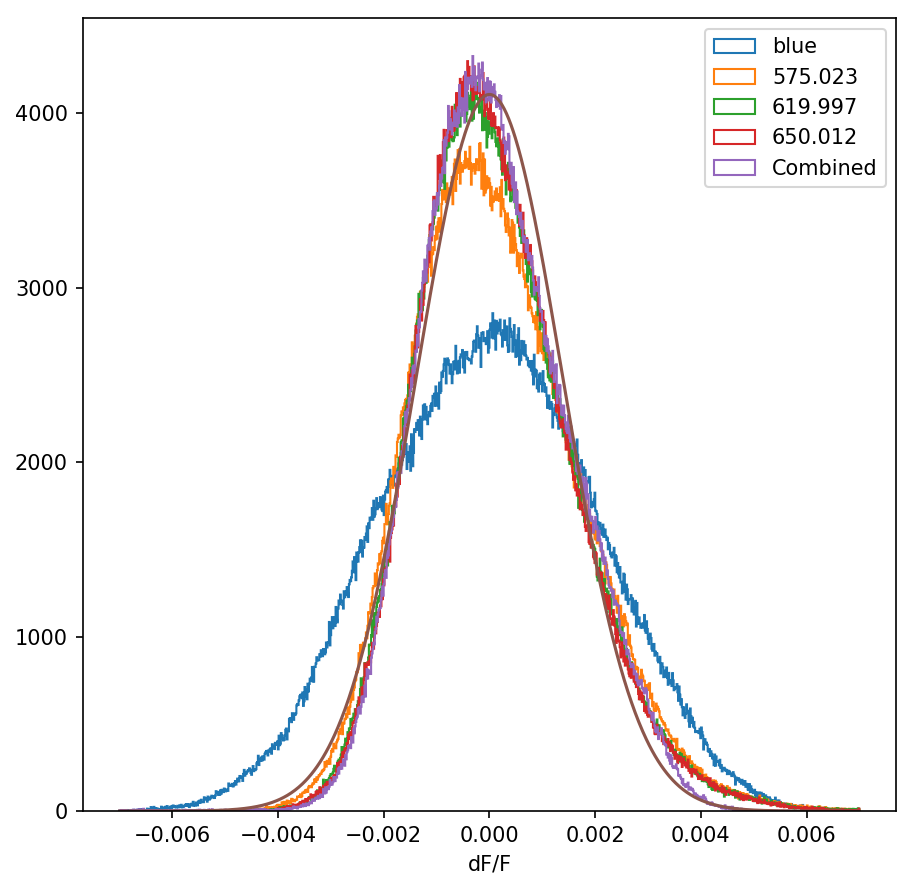

In [119]:
from scipy import signal


fig, axs = pylab.subplots(1,1,figsize=(7,7),dpi=150)

range = (-0.007,0.007)
nbins = 1000
for anarray, label in [
            ( normedblue.flatten(), "blue" ),
#            ( normedimg.flatten(), "Combined" ),
            getonewl(11),
            getonewl(13),
            getonewl(15),
            ( normedimg.flatten(), "Combined" ),    
#            ( red.mean(), r"$\langle {\rm red}\rangle$-red" )    
    ]:
    arr = gaussian_filter(anarray-red.flatten(),sigma=sigma)/red.flatten()
    s = mad_std(arr)
    print("{:.2}%".format(s*100))    
    pylab.hist(arr-numpy.median(arr),
               bins=nbins,range=range,histtype="step",label=label)
dx= (range[-1]-range[0])/nbins
x = numpy.arange(*range,dx)
s = mad_std(arr)
y = numpy.exp(-x**2/(2*s**2))/numpy.sqrt(2*numpy.pi*s**2)*dx*arr.shape[0]
print("{:.2}%".format(s*100))
pylab.plot(x,y)
pylab.xlabel("dF/F")
pylab.legend()